# Carbon Tax Analysis: A Difference in Differences Approach
### Chandler Fahr

Carbon Taxes are gaining interest countrywide as a way to mitigate the harmful effects of Co2 emissions while generating state revenue. The rules imposed fees on the emission of greenhouse gases, and some of the fees have exceeded $50,000 annually, generating millions of dollars over its existence. Several studies have shown that the tax effectively lowers emimission, but his project will seek to find other effects such as air quality.

The San Francisco Bay Area implemented a carbon tax (bill AB32) in 2008 - This analysis will use a simple difference in differences design with Santa Clara county (the location of San Jose) as the treatment area and King county (the location of Seattle) as the control location, a comparable west coast metropolitan area that does not have a carbon tax.

### Carbon Emissions by Sector
The figure below shows that energy producers and consumers are some of the largest emitters of carbon, thus this study will focus on changes in energy consumption and costs.

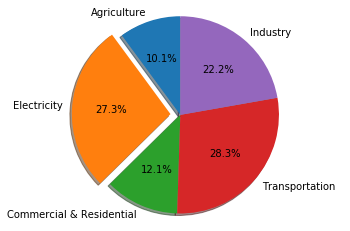

In [122]:
labels = 'Agriculture', 'Electricity', 'Commercial & Residential', 'Transportation', 'Industry'
sizes = [10, 27, 12, 28, 22]
explode = (0, 0.1, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

The data used is presented in part below,

In [123]:
import altair as alt
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
df = pd.read_csv("/Users/chandlerfahr/Desktop/Project2.csv")
df.head()

,Year,county,electricity,gas,aqi,cost,treatment,post,population
0,2003,Santa Clara,15183.038,482.424,12.06,11.78,1,0,1673000
1,2004,Santa Clara,15359.470,510.846,10.71,11.35,1,0,1676000
2,2005,Santa Clara,15566.040,462.871,10.97,11.63,1,0,1691000
3,2006,Santa Clara,16058.130,485.145,8.39,12.82,1,0,1709000
4,2007,Santa Clara,16459.770,472.156,7.95,12.80,1,0,1733000


# Air Quality Index

The air quality index (AQI) is a measure of air quality/polution in a given area. Here we compare the AQI of King and Santa Clara county after the implementation of the carbon tax. Prior studies indicate a stong reduction in polutants when a carbon tax is introduced, therefore it can be assumed that air quality should see an improvement.

In [87]:
df['treatxpost'] = df['treatment'] * df['post']

X = df[['treatment','post', 'treatxpost']]
X = sm.add_constant(X)

results = sm.OLS(df['aqi'], X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    aqi   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     18.24
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           1.08e-05
Time:                        19:30:23   Log-Likelihood:                -51.637
No. Observations:                  22   AIC:                             111.3
Df Residuals:                      18   BIC:                             115.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.9560      1.251     13.556      0.000      14.328      19.584
treatment     -6.9400      1.769     -3.923      0.001     -10.656      -3.224
post         -11.7643      1.694     -6.946      0.000     -15.323      -8.206
treatxpost     8.7483      2.395      3.653      0.002       3.716      13.780
==============================================================================
Omnibus:                        0.754   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.686   Jarque-Bera (JB):                0.194
Skew:                          -0.225   Prob(JB):                        0.908
Kurtosis:                       3.093   Cond. No.                         7.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\beta_{0}$: Mean Seattle AQI prior to 2008 \
$\beta_{Treatment}$: Difference in average AQI between the two counties prior to 2008 \
$\beta_{Post}$: Difference in Seattle's average AQI before and after 2008\
$\beta_{Treatment * Post}$: Difference in difference estimate of the effect of the carbon tax on AQI 

According to this model, the implementation of the carbon tax increases AQI by a value of 8.73 points

This of course goes against the intuition that a levyed carbon tax would increase air quality. The following plots show that Seattle would not work as a counterfactual.

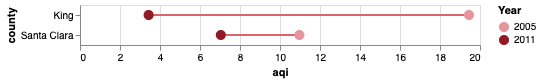

In [88]:
chart = alt.layer(
    data=df
).transform_filter(
    filter={"field": 'county',
            "oneOf": ["Santa Clara", "King"]}
).transform_filter(
    filter={'field': 'Year',
            "oneOf": [2005, 2011]}
)

chart += alt.Chart().mark_line(color='#db646f').encode(
    x='aqi:Q',
    y='county:N',
    detail='county:N'
)

chart += alt.Chart().mark_point(
    size=100,
    opacity=1,
    filled=True
).encode(
    x='aqi:Q',
    y='county:N',
    color=alt.Color('Year:O',
        scale=alt.Scale(
            domain=['2005', '2011'],
            range=['#e6959c', '#911a24']
        )
    )
).interactive()

chart

Here we see that Seattle dramatically reduced it's average AQI between 2005 and 2011. Comparatively, Santa Clara county made very little improvement in air quality during that time, despite the implementation of the carbon tax.

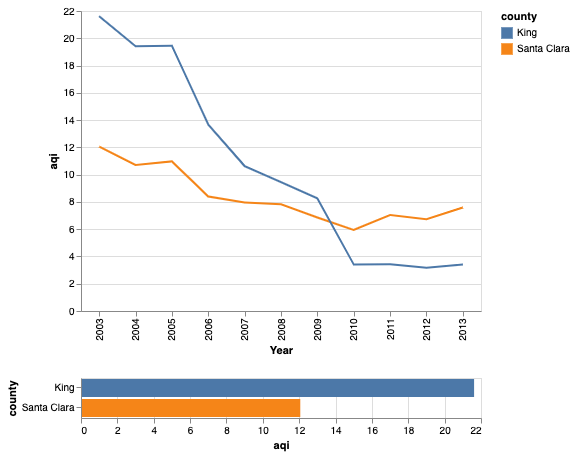

In [89]:
brush = alt.selection_interval()

points = alt.Chart(df).mark_line().properties(width=400).encode(
    x='Year:N',
    y='aqi',
    color=alt.condition(brush, 'county:N', alt.value('lightgray'))
).add_selection(
    brush
)
bars = alt.Chart(df).mark_bar().properties(width=400).encode(
    y='county:N',
    color='county:N',
    x='aqi:Q'
).transform_filter(
    brush
)
points & bars

The figure above shows that the paralell trend assumption of the DID model is broken after 2005 when Seattle made dramatic progress in improving air quality. 
Reasons for this may be car emission standards in Washington state which caught up to those in California throughout the 2000's. Wildfires that have become increasingly common in northern California over the last 20 years, which may have overshadowed the effects of emission reduction

# Electricity Consumption per Capita

To examine the direct effect of the tax on energy consumption, from both residential and industrail entities, the following two model will attempt to measure the reduction in electricity and gas usage per capita before and after its implementation. 

In [107]:
df['pop_million'] = df['population'] / 1000000
df['electricity_pc'] = df['electricity'] / df['pop_million']
results = sm.OLS(df['electricity_pc'], X).fit()
results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         electricity_pc   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     265.9
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           4.33e-15
Time:                        19:37:38   Log-Likelihood:                -140.82
No. Observations:                  22   AIC:                             289.6
Df Residuals:                      18   BIC:                             294.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.11e+04     72.072    154.027      0.000    1.09e+04    1.13e+04
treatment  -1833.2249    101.925    -17.986      0.000   -2047.361   -1619.088
post          63.9476     97.586      0.655      0.521    -141.072     268.968
treatxpost  -192.3877    138.007     -1.394      0.180    -482.330      97.554
==============================================================================
Omnibus:                        0.993   Durbin-Watson:                   0.656
Prob(Omnibus):                  0.609   Jarque-Bera (JB):                0.833
Skew:                           0.436   Prob(JB):                        0.659
Kurtosis:                       2.616   Cond. No.                         7.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\beta_{0}$: Average kilowatt-hours consumed per capita in Seattle prior to 2008 \
$\beta_{Treatment}$: Difference in kilowatt-hours consumed per capita between the two counties prior to 2008 \
$\beta_{Post}$: Difference in Seattle's kilowatt-hours consumed per capita before and after 2008\
$\beta_{Treatment * Post}$: Difference in difference estimate of the effect of the carbon tax on kilowatt-hours of electricity consumed 

According to this model, the implementation of the carbon tax decreases electricity consumed per capita by 192.39 kilowatt-hours.

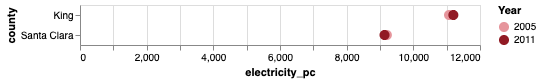

In [110]:
chart = alt.layer(
    data=df
).transform_filter(
    filter={"field": 'county',
            "oneOf": ["Santa Clara", "King"]}
).transform_filter(
    filter={'field': 'Year',
            "oneOf": [2005, 2011]}
)

chart += alt.Chart().mark_line(color='#db646f').encode(
    x='electricity_pc:Q',
    y='county:N',
    detail='county:N'
)

chart += alt.Chart().mark_point(
    size=100,
    opacity=1,
    filled=True
).encode(
    x='electricity_pc:Q',
    y='county:N',
    color=alt.Color('Year:O',
        scale=alt.Scale(
            domain=['2005', '2011'],
            range=['#e6959c', '#911a24']
        )
    )
).interactive()

chart

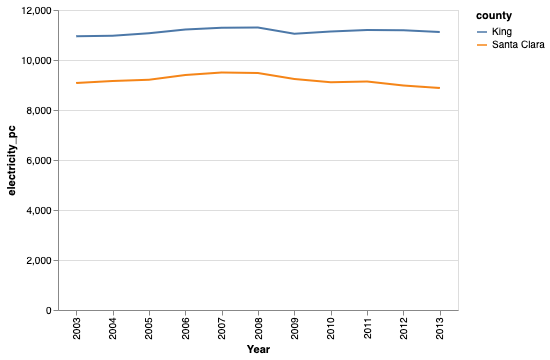

In [109]:
points = alt.Chart(df).mark_line().properties(width=400).encode(
    x='Year:N',
    y='electricity_pc',
    color=alt.condition(brush, 'county:N', alt.value('lightgray'))
).add_selection(
    brush)

points.interactive()

This figure ensures a pre-existing parrallel trend between the two counties. Both follow a similiar pattern prior to the treatment in 2008. Afterward, we see the the energy consumed per capita plateus in King county and decreases in Santa Clara. This suggests that the carbon tax may be transfered from energy companies to consumers through electrcity costs.  

# Gas Consumption per Capita

In [77]:
df['gas_pc'] = df['gas'] / df['pop_million']
results = sm.OLS(df['gas_pc'], X).fit()
results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 gas_pc   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     93.46
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           3.63e-11
Time:                        19:03:40   Log-Likelihood:                -79.697
No. Observations:                  22   AIC:                             167.4
Df Residuals:                      18   BIC:                             171.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        339.0948      4.478     75.717      0.000     329.686     348.504
treatment    -54.4524      6.334     -8.598      0.000     -67.759     -41.146
post          -1.9660      6.064     -0.324      0.750     -14.706      10.774
treatxpost   -26.1165      8.576     -3.045      0.007     -44.133      -8.100
==============================================================================
Omnibus:                        2.620   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.270   Jarque-Bera (JB):                1.845
Skew:                           0.706   Prob(JB):                        0.397
Kurtosis:                       2.866   Cond. No.                         7.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\beta_{0}$: Mean therms consumed per capita in Seattle prior to 2008 \
$\beta_{Treatment}$: Difference in therms consumed per capita between the two counties prior to 2008 \
$\beta_{Post}$: Difference in Seattle's therms consumed per capita before and after 2008\
$\beta_{Treatment * Post}$: Difference in difference estimate of the effect of the carbon tax on therms of gas consumed 

According to this model, the implementation of the carbon tax decreases gas consumed per capita by 26.11 therms. However, unlike energy we cannot claim to have an appropriate counterfactual in this model.

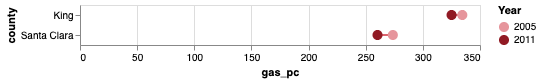

In [83]:
chart = alt.layer(
    data=df
).transform_filter(
    filter={"field": 'county',
            "oneOf": ["Santa Clara", "King"]}
).transform_filter(
    filter={'field': 'Year',
            "oneOf": [2005, 2011]}
)

chart += alt.Chart().mark_line(color='#db646f').encode(
    x='gas_pc:Q',
    y='county:N',
    detail='county:N'
)

chart += alt.Chart().mark_point(
    size=100,
    opacity=1,
    filled=True
).encode(
    x='gas_pc:Q',
    y='county:N',
    color=alt.Color('Year:O',
        scale=alt.Scale(
            domain=['2005', '2011'],
            range=['#e6959c', '#911a24']
        )
    )
).interactive()

chart

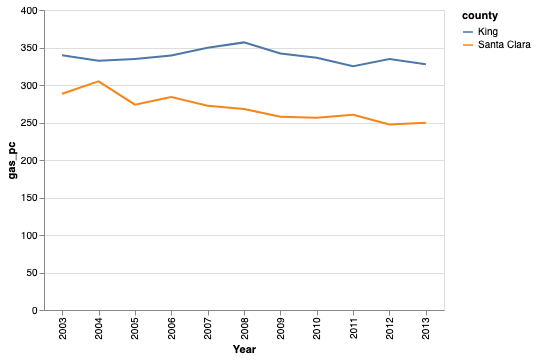

In [84]:
points = alt.Chart(df).mark_line().properties(width=400).encode(
    x='Year:N',
    y='gas_pc',
    color=alt.condition(brush, 'county:N', alt.value('lightgray'))
).add_selection(
    brush)

points.interactive()

# Cost of Energy

It is often the case that producers transfer the burden of a new tax on consumers. This model will try to estimate the increase in costs expirenced by Bay Area residents and businesses after the tax was instated. 

In [23]:
results = sm.OLS(df['cost'], X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     319.9
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           8.48e-16
Time:                        14:20:22   Log-Likelihood:                -13.007
No. Observations:                  22   AIC:                             34.01
Df Residuals:                      18   BIC:                             38.38
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0080      0.216     27.805      0.000       5.554       6.462
treatment      6.0680      0.306     19.857      0.000       5.426       6.710
post           0.7603      0.293      2.599      0.018       0.146       1.375
treatxpost     0.4337      0.414      1.048      0.308      -0.436       1.303
==============================================================================
Omnibus:                        1.808   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                0.999
Skew:                           0.521   Prob(JB):                        0.607
Kurtosis:                       3.051   Cond. No.                         7.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\beta_{0}$: Mean cost of energy in Seattle prior to 2008 (cents per kwh) \
$\beta_{Treatment}$: Difference in cost of energy between the two counties prior to 2008 (cents per kwh)\
$\beta_{Post}$: Difference in Seattle's average cost of energy before and after 2008 (cents per kwh)\
$\beta_{Treatment * Post}$: Difference in difference estimate of the effect of the carbon tax on the cost of energy\

According to this model, the cost of energy increased by 0.43 cents per killowatt-hour due to the implementation of the carbon tax. A modest increase considering the heavy taxes burdened by gass and power companies. Again let us visualize the data. 


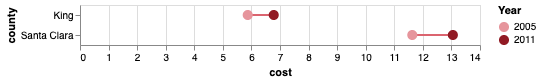

In [24]:
chart = alt.layer(
    data=df
).transform_filter(
    filter={"field": 'county',
            "oneOf": ["Santa Clara", "King"]}
).transform_filter(
    filter={'field': 'Year',
            "oneOf": [2005, 2011]}
)

chart += alt.Chart().mark_line(color='#db646f').encode(
    x='cost:Q',
    y='county:N',
    detail='county:N'
)

chart += alt.Chart().mark_point(
    size=100,
    opacity=1,
    filled=True
).encode(
    x='cost:Q',
    y='county:N',
    color=alt.Color('Year:O',
        scale=alt.Scale(
            domain=['2005', '2011'],
            range=['#e6959c', '#911a24']
        )
    )
).interactive()

chart

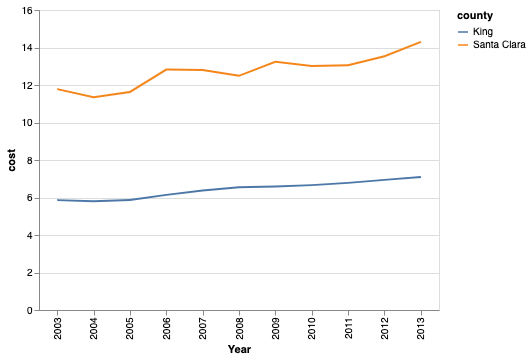

In [79]:
points = alt.Chart(df).mark_line().properties(width=400).encode(
    x='Year:N',
    y='cost:Q',
    color=alt.condition(brush, 'county:N', alt.value('lightgray'))
).add_selection(
    brush
).interactive()

points

In this figure we see again that King county is not an appropriate counter factual for Santa Clara. Upon further research it was found that the majority of Washington's energy was produced from natural gas, whereas California relies more heavily on natural gas - this may explain the fluctuations in prices in Santa Clara's prices for energy compared to the relatively consistant prices in King county.
The higher prices in Santa Clara may also explain the relatively small amount of electricity and gas consumed there compared to King county.

# Conclusion

Across these models it became increasingly clear that Seattle was not fit to act as a counterfactual for San Jose for various reasons. Additonally, chagnes in all the factors described above may not necessarily be the result of the carbon tax given many external forces.

A caveat discovered in this analysis is the comparison of AQI between two locations. Considering weather and geography it could be difficult to measure polutants based soley on air quality. Los Angeles for example emits a great amount of pollutants but much of it is blown into the southern San Joaquin Vally by coastal winds. Below is a plot that renforces the idea that energy usage and AQI have a loose relationship at best. 

In [152]:
df2 = pd.read_csv("/Users/chandlerfahr/Desktop/conclusion.csv")
df2.head()

,state,bill,usage,population,aqi
0,Alaska,195.10,822,710231,29.1
1,Alabama,106.29,390,4779736,46.6
2,Arkansas,83.42,352,6392017,45.4
3,Arizona,109.52,209,2915918,43.1
4,California,164.51,200,37253956,46.0


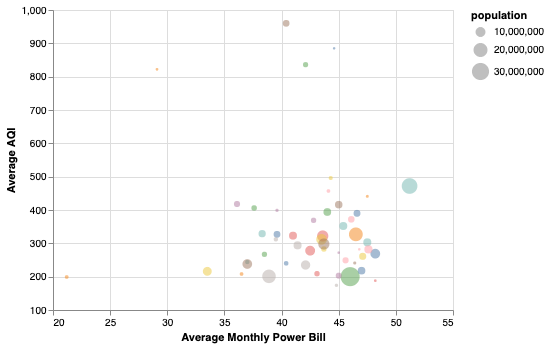

In [156]:
alt.Chart(df2).mark_point(filled=True).encode(
    alt.X('aqi:Q', scale=alt.Scale(zero=False), title="Average Monthly Power Bill"),
    alt.Y('usage:Q', scale=alt.Scale(zero=False), title="Average AQI"),
    alt.Size('population:Q'),
    alt.Color('state:N', legend=None),
    alt.OpacityValue(0.5),
    tooltip = [alt.Tooltip('state:N'),
               alt.Tooltip('population:Q'),
               alt.Tooltip('bill:Q'),
               alt.Tooltip('usage:Q')
              ]
).interactive()

Lastly, it is important to note that despite a delay in charges, energy prices do effect usage as seen in the plot below. Carbon taxs will surely be passed onto consumers, reducing consumption, and ultimatly moving us toward a more sustainable future. A nationwide carbon tax will not only reduce emmissions from large power an oil companies, but also being necessary change to consumers and other businesses. 

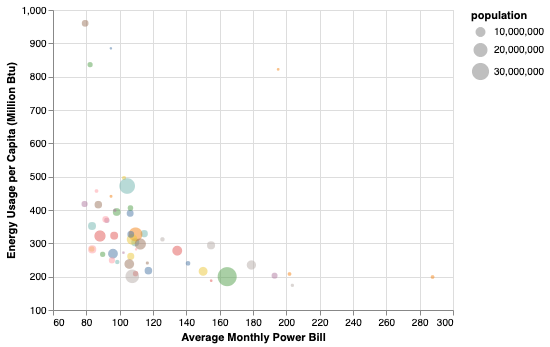

In [149]:
alt.Chart(df2).mark_point(filled=True).encode(
    alt.X('bill:Q', scale=alt.Scale(zero=False), title="Average Monthly Power Bill"),
    alt.Y('usage:Q', scale=alt.Scale(zero=False), title="Energy Usage per Capita (Million Btu)"),
    alt.Size('population:Q'),
    alt.Color('state:N', legend=None),
    alt.OpacityValue(0.5),
    tooltip = [alt.Tooltip('state:N'),
               alt.Tooltip('population:Q'),
               alt.Tooltip('bill:Q'),
               alt.Tooltip('usage:Q')
              ]
).interactive()

# References

#### 1) US Energy Information Administration: Independent Statistics & Analysis
  2018, Electric Sales, Revenue, and Average Price: https://www.eia.gov/electricity/sales_revenue_price/index.php \
  2017, Total Energy Consumed per Capita: https://www.eia.gov/state/rankings/
  
#### 2) Environment + Energy Leader
  Natsu, P. 2008, S.F. Bay Area Passes Carbon Tax: https://www.environmentalleader.com/2008/05/sf-bay-area-passes-carbon-tax/#:~:text=The%20San%20Francisco%20Bay%20Area,U.S.%2CThe%20Associated%20Press%20reports. 

#### 3) US Environmental Protection Agency
   2018, Sources of Greenhouse Gas Emissions: https://www.epa.gov/ghgemissions/sources-greenhouse-gas-emissions#Electricity_ref \
   2020, Air Quality Index Daily Values Report: https://www.epa.gov/outdoor-air-quality-data/air-quality-index-daily-values-report
   
#### 4) King County: Office of the Executive
   2018, Energy Consumption: https://www.kingcounty.gov/depts/executive/performance-strategy-budget/regional-planning/benchmark-program/Environment/EN11_EnergyConsumption.aspx
   
#### 5) California Energy Commission
   2018, Gas Consumption by County: https://ecdms.energy.ca.gov/gasbycounty.aspx \
   2018, Electricity Consumption by County: https://ecdms.energy.ca.gov/elecbycounty.aspx

#### 6) Unitied States Census Bureau
   2019, State Population Totals and Components of Change: 2010-2019: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html#par_textimage_1574439295
   